In [11]:
import json
import os

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from upsetplot import UpSet, from_memberships
from typing import List, Dict, Literal

In [12]:
Part = Literal["sentence", "paragraph", "page"]
Language = Literal["en", "sk", "de"]
Model = Literal["e5", "labse", "gte"]
Id = str

PARTS: List[Part] = ["page", "paragraph", "sentence"]
LANGUAGES: List[Language] = ["en", "sk", "de"]
ALL_MODELS: List[Model] = ["e5", "labse", "gte"]
PG_TGRM = "tgrm"
CHAT_GPT = "gpt"

ALL_MODELS = [PG_TGRM, *ALL_MODELS]

DATA_DIR = "../../data"
OUT_DIR = "../../out"

SPACE = " "

In [13]:
with open(f"{DATA_DIR}/dataset/03_judgements.json", "r") as file:
    judgements_by_query: Dict[str, List[str]] = json.load(file)

with open(f"{DATA_DIR}/library/metadata.json", "r") as file:
    all_document_ids = [doc["pk"] for doc in json.load(file)]

with open(f"{DATA_DIR}/dataset/02_queries-EN.json", "r") as file:
    en_queries: List[str] = json.load(file)
with open(f"{DATA_DIR}/dataset/02_queries-SK.json", "r") as file:
    sk_queries: List[str] = json.load(file)
with open(f"{DATA_DIR}/dataset/02_queries-DE.json", "r") as file:
    de_queries: List[str] = json.load(file)

queries_by_language = {
    "en": en_queries,
    "sk": sk_queries,
    "de": de_queries
}

In [14]:
COLORS = [
    "#CC1F1A",
    "#1F9D55",
    "#2779BD",
    "#794ACF",
    "#EF5753",
    "#51D88A",
    "#6CB2EB",
    "#A779E9"
]

In [15]:
def set_attr(obj: dict, path: str, value, *, append: bool = False):
    keys = path.split(".")
    last_key = keys[-1]

    for key in keys[:-1]:
        if key not in obj:
            obj[key] = {}

        obj = obj[key]

    if last_key in obj:
        if append:
            obj[last_key].append(value)
        else:
            obj[last_key] = value
    else:
        if append:
            obj[last_key] = [value]
        else:
            obj[last_key] = value


def get_attr(obj: dict, path: str):
    keys = path.split(".")
    last_key = keys[-1]

    for key in keys[:-1]:
        if key not in obj:
            return None

        obj = obj[key]

    if last_key not in obj:
        return None

    return obj[last_key]


def plm():
    result = []

    for part in PARTS:
        for lang in LANGUAGES:
            for model in ALL_MODELS:
                result.append((part, lang, model))

    return result


def plmi():
    result = []

    for part, lang, model in plm():
        for idx in range(len(queries_by_language[lang])):
            result.append((part, lang, model, idx))

    return result


def get_id(part: Part, lang: Language, idx: int) -> Id:
    return f"{part}-{lang}-{idx + 1}"


def get_retrieval_path(model: Model, id: Id):
    return f"{DATA_DIR}/retrieval/{model}/{id}.json"


def normalize(maxx, minn, similarity):
    return (similarity - minn) / (maxx - minn)


def get_top_docs(docs, coeff: float):
    if len(docs) == 0:
        return []

    top_doc = docs[0]
    top_similarity = top_doc["similarity"]
    similarity_threshold = top_similarity * (1 - coeff)

    return list(filter(
        lambda doc: doc["similarity"] >= similarity_threshold,
        docs
    ))


def get_ordering_score(docs_1, docs_2):
    score = 0

    l1 = len(docs_1)
    l2 = len(docs_2)

    if min(l1, l2) == 0:
        return 0

    for i in range(min(l1, l2)):
        doc_1 = docs_1[i]
        doc_2 = docs_2[i]

        if doc_1["id"] == doc_2["id"]:
            score += 1 / (i + 1)

    n = sum([1 / (i + 1) for i in range(min(l1, l2))])

    match_score = score / n
    return match_score


def get_intersection_score(docs_1, docs_2):
    def get_doc_id(doc):
        return doc["id"]

    doc_ids_1 = list(map(get_doc_id, docs_1))
    doc_ids_2 = list(map(get_doc_id, docs_2))

    l1 = len(doc_ids_1)
    l2 = len(doc_ids_2)

    if min(l1, l2) == 0:
        return 0

    intersection = set(doc_ids_1).intersection(set(doc_ids_2))
    union = set(doc_ids_1).union(set(doc_ids_2))
    n = len(union)

    return len(intersection) / n


def to_csv(df, name):
    base_dir = f"{DATA_DIR}/results"
    os.makedirs(f"{base_dir}", exist_ok=True)
    df.to_csv(f"{base_dir}/{name}.csv")


def print_list(lst):
    print(", ".join(map(str, lst)))


def get_counts_for_metrics(docs, reference_retrieval):
    bad = set(all_document_ids).difference(set(reference_retrieval))
    not_returned = set(all_document_ids).difference(set(docs))

    tp = len(set(docs).intersection(set(reference_retrieval)))
    tn = len(bad.union(not_returned))
    fp = len(set(docs).difference(set(reference_retrieval)))
    fn = len(set(reference_retrieval).difference(set(docs)))

    return tp, tn, fp, fn


def calculate_accuracy(counts):
    tp, tn, fp, fn = counts
    return (tp + tn) / (tp + tn + fp + fn)


def calculate_precision(counts):
    tp, tn, fp, fn = counts

    if tp + fp == 0:
        return 0

    return tp / (tp + fp)


def calculate_recall(counts):
    tp, tn, fp, fn = counts
    return tp / (tp + fn)


def calculate_f1(counts):
    precision = calculate_precision(counts)
    recall = calculate_recall(counts)

    if precision + recall == 0:
        return 0

    return 2 * (precision * recall) / (precision + recall)

In [16]:
RETRIEVALS = {}

for part, lang, model, idx in plmi():
	RETRIEVALS[(
		part, lang, model, idx
	)] = json.load(open(get_retrieval_path(
		model, get_id(part, lang, idx)
	), "r"))

In [17]:
# Similarity normalized by model and by model-part

similarities = {}

for part in PARTS:
	for lang in LANGUAGES:
		for model in ALL_MODELS:
			for idx, query in enumerate(queries_by_language[lang]):
				id = get_id(part, lang, idx)
				retrieval = RETRIEVALS[(part, lang, model, idx)]

				for doc in retrieval["documents"]:
					similarity = doc["similarity"]

					if similarity == 0:
						continue

					set_attr(
						similarities,
						model,
						similarity,
						append=True
					)

					set_attr(
						similarities,
						f"{model}-{part}",
						similarity,
						append=True
					)

normalization_params = {}

for group, group_similarities in similarities.items():
	max_sim = max(group_similarities)
	min_sim = min(group_similarities)
	normalization_params[group] = (max_sim, min_sim)


In [18]:
# Average similarities by unit

data_by_model_part = {}
data_by_model_lang = {}
normalized_retrievals_per_model = {}
normalized_retrievals_per_model_part = {}

for model in ALL_MODELS:
	max_sim, min_sim = normalization_params[model]

	for part in PARTS:
		for lang in LANGUAGES:
			for idx, query in enumerate(queries_by_language[lang]):
				retrieval = RETRIEVALS[(part, lang, model, idx)]
				normalized_docs = []

				for doc in retrieval["documents"]:
					similarity = doc["similarity"]

					if similarity == 0:
						continue

					normalized_similarity = normalize(
						max_sim, min_sim, similarity
					)

					normalized_docs.append({
						**doc,
						"similarity": normalized_similarity
					})

				normalized_retrievals_per_model[
					(model, part, lang, idx)
				] = {
					**retrieval,
					"documents": normalized_docs
				}

				for doc in get_top_docs(normalized_docs, 0.10):
					set_attr(
						data_by_model_part,
						f"{model}.{part}",
						doc["similarity"],
						append=True
					)

					set_attr(
						data_by_model_lang,
						f"{model}.{lang}",
						doc["similarity"],
						append=True
					)


for model in ALL_MODELS:
	for part in PARTS:
		max_sim, min_sim = normalization_params[f"{model}-{part}"]

		for lang in LANGUAGES:
			for idx, query in enumerate(queries_by_language[lang]):
				retrieval = RETRIEVALS[(part, lang, model, idx)]
				normalized_docs = []

				for doc in retrieval["documents"]:
					similarity = doc["similarity"]

					if similarity == 0:
						continue

					normalized_similarity = normalize(
						max_sim, min_sim, similarity
					)

					normalized_docs.append({
						**doc,
						"similarity": normalized_similarity
					})

				normalized_retrievals_per_model_part[
					(model, part, lang, idx)
				] = {
					**retrieval,
					"documents": normalized_docs
				}

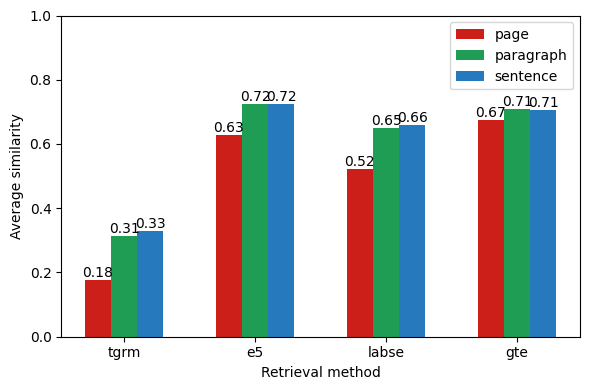

In [19]:
x = np.arange(len(ALL_MODELS))
width = 0.2

fig, ax = plt.subplots(figsize=(6, 4))

for i, part in enumerate(PARTS):
	values = []

	for model in ALL_MODELS:
		avg = sum(data_by_model_part[model][part]) / len(data_by_model_part[model][part])
		values.append(avg)

	ax.bar(
		x - width + i * width, values, width,
		label=part, color=COLORS[i]
	)

	ax.bar_label(ax.containers[i], fmt='%.2f', label_type='edge')

ax.set_ybound(0, 1)
ax.set_xlabel('Retrieval method')
ax.set_ylabel('Average similarity')
ax.set_xticks(x)
ax.set_xticklabels(ALL_MODELS)
ax.legend()

plt.tight_layout()
plt.savefig(f"{OUT_DIR}/results/granularity-impact.png", dpi=300)
plt.show()

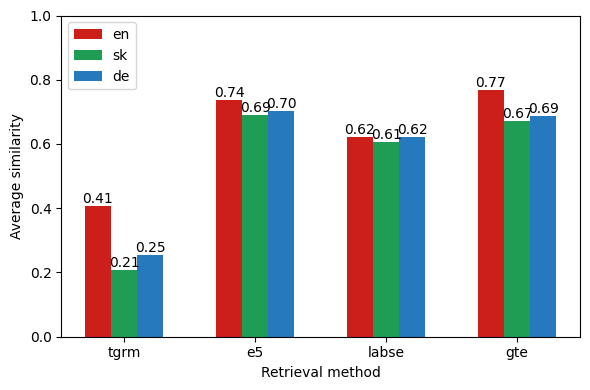

In [20]:
x = np.arange(len(ALL_MODELS))
width = 0.2

fig, ax = plt.subplots(figsize=(6, 4))

for i, lang in enumerate(LANGUAGES):
	values = []

	for model in ALL_MODELS:
		data = data_by_model_lang[model][lang]
		avg = sum(data) / len(data)
		values.append(avg)

	ax.bar(
		x - width + i * width, values, width,
		label=lang, color=COLORS[i]
	)

	ax.bar_label(ax.containers[i], fmt='%.2f')

ax.set_ybound(0, 1)
ax.set_xlabel('Retrieval method')
ax.set_ylabel('Average similarity')
ax.set_xticks(x)
ax.set_xticklabels(ALL_MODELS)
ax.legend()

plt.tight_layout()
plt.savefig(f"{OUT_DIR}/results/language-impact.png", dpi=300)
plt.show()

page


/Users/milanmarcinco/School/bak/env/lib/python3.9/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/Users/milanmarcinco/School/bak/env/lib/python3.9/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["lin

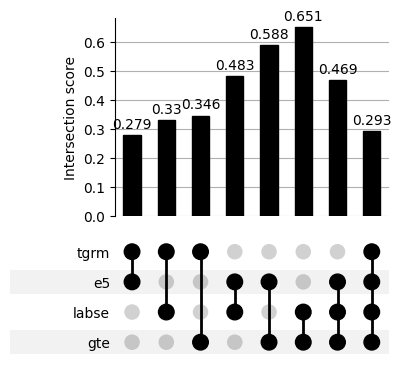

paragraph
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


/Users/milanmarcinco/School/bak/env/lib/python3.9/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/Users/milanmarcinco/School/bak/env/lib/python3.9/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["lin

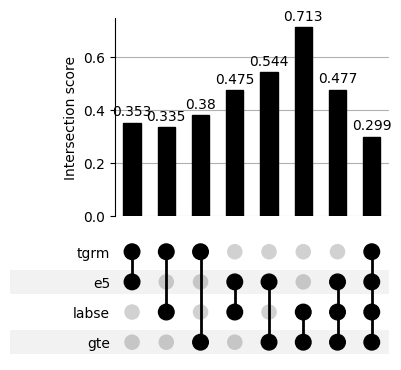

sentence
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


/Users/milanmarcinco/School/bak/env/lib/python3.9/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/Users/milanmarcinco/School/bak/env/lib/python3.9/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["lin

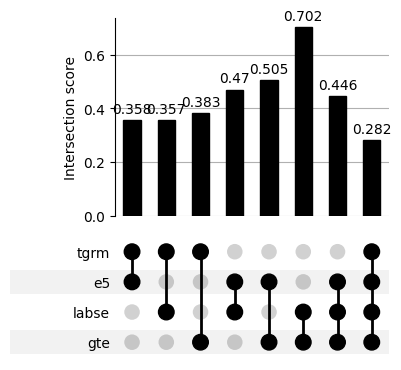

In [21]:
intersections = [
    ['tgrm', 'e5'],
    ['tgrm', 'labse'],
    ['tgrm', 'gte'],
    ['e5', 'labse'],
    ['e5', 'gte'],
    ['labse', 'gte'],

    ['e5', 'labse', 'gte'],
    ['tgrm', 'e5', 'labse', 'gte'],

    # ['tgrm', 'gpt'],
    # ['e5', 'gpt'],
    # ['labse', 'gpt'],
    # ['gte', 'gpt']
]

for part in PARTS:
    print(part)
    intersection_sizes = []

    for models in intersections:
        tmp_intersection_sizes = []

        for lang in LANGUAGES:
            for idx, query in enumerate(queries_by_language[lang]):
                sets = {}

                for model in models:
                    retrieval = normalized_retrievals_per_model_part[
                        (model, part, lang, idx)
                    ]

                    docs = [
                        f"{doc['id']}-{lang}-{idx}"
                        for doc in get_top_docs(
                            retrieval["documents"],
                            0.10
                        )
                    ]

                    if model in sets:
                        sets[model].update(docs)
                    else:
                        sets[model] = set(docs)

                final_set_a = None
                final_set_u = None

                for model in models:
                    target_set = sets[model]

                    if final_set_a is None:
                        final_set_a = target_set
                        final_set_u = target_set
                    else:
                        final_set_a = final_set_a.intersection(target_set)
                        final_set_u = final_set_a.union(target_set)

                if len(final_set_u) == 0:
                    print(len(final_set_a), len(final_set_u))
                    continue

                ratio = len(final_set_a) / len(final_set_u)
                tmp_intersection_sizes.append(ratio)

        avg = sum(tmp_intersection_sizes) / len(tmp_intersection_sizes)
        intersection_sizes.append(avg)

    # sets[CHAT_GPT] = set([
    #     f"{doc_id}-{lang}-{idx}"
    #     for lang in LANGUAGES
    #     for idx, query in enumerate(queries_by_language["en"])
    #     for doc_id in judgements_by_query[query]
    # ])

    upset_plot = UpSet(
        data=from_memberships(intersections, intersection_sizes),
        show_counts=False,
        show_percentages=False,
        sort_by="input",
        totals_plot_elements=False,
    ).plot()

    for bar in upset_plot['intersections'].patches:
        y = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2
        label = round(y, 3)

        upset_plot['intersections'].annotate(
            label, (x, y),
            textcoords="offset points",
            xytext=(0, 5),
            ha='center'
        )

    upset_plot['intersections'].set_ylabel('Intersection score')

    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/results/intersection-scores-{part}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [22]:
row_labels = [
    "tgrm",
    "e5",
    "labse",
    "gte",
]

column_tuples = [
    ("English", "precision"),
    ("English", "recall"),
    ("English", "f1"),
    ("Slovak", "precision"),
    ("Slovak", "recall"),
    ("Slovak", "f1"),
    ("German", "precision"),
    ("German", "recall"),
    ("German", "f1"),
]

columns = pd.MultiIndex.from_tuples(column_tuples)

for part in PARTS:
    rows = []

    for model in ALL_MODELS:
        row = []

        for lang in LANGUAGES:
            metrics_result = {}

            for idx, query in enumerate(queries_by_language["en"]):
                retrieval = normalized_retrievals_per_model_part[
                    (model, part, lang, idx)
                ]

                reference_retrieval = judgements_by_query[query]

                docs = [
                    doc["id"]
                    for doc in get_top_docs(
                        retrieval["documents"],
                        0.10
                    )
                ]

                tp, tn, fp, fn = get_counts_for_metrics(
                    docs, reference_retrieval)

                accuracy = calculate_accuracy((tp, tn, fp, fn))
                precision = calculate_precision((tp, tn, fp, fn))
                recall = calculate_recall((tp, tn, fp, fn))
                f1 = calculate_f1((tp, tn, fp, fn))

                # set_attr(metrics_result, "accuracy", accuracy, append=True)
                set_attr(metrics_result, "precision", precision, append=True)
                set_attr(metrics_result, "recall", recall, append=True)
                set_attr(metrics_result, "f1", f1, append=True)

            for metric in ["precision", "recall", "f1"]:
                values = list(filter(
                    lambda x: x is not None,
                    get_attr(metrics_result, metric)
                ))

                avg = sum(values) / len(values)
                row.append(round(avg, 3))

        rows.append(row)

    df = pd.DataFrame(
        data=rows,
        index=row_labels,
        columns=columns
    )

    print(f"{part}:")
    print(df, end="\n\n\n")

page:
        English                  Slovak                  German              
      precision recall     f1 precision recall     f1 precision recall     f1
tgrm      0.545  0.332  0.349     0.241  0.200  0.186     0.306  0.219  0.215
e5        0.587  0.580  0.487     0.195  0.327  0.175     0.258  0.370  0.227
labse     0.533  0.486  0.427     0.438  0.458  0.362     0.444  0.436  0.354
gte       0.903  0.619  0.651     0.771  0.619  0.583     0.815  0.619  0.612


paragraph:
        English                  Slovak                  German              
      precision recall     f1 precision recall     f1 precision recall     f1
tgrm      0.651  0.454  0.461     0.152  0.134  0.116     0.236  0.198  0.185
e5        0.628  0.532  0.491     0.151  0.198  0.131     0.229  0.354  0.225
labse     0.643  0.525  0.483     0.506  0.476  0.390     0.523  0.463  0.400
gte       0.867  0.597  0.629     0.739  0.595  0.561     0.761  0.598  0.579


sentence:
        English                  